In [ ]:
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600
from keras.utils import np_utils as utils
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.models import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

## Загрузка и подготовка датасета

In [ ]:
BATCH_SIZE = 32
EPOCHS = 40
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


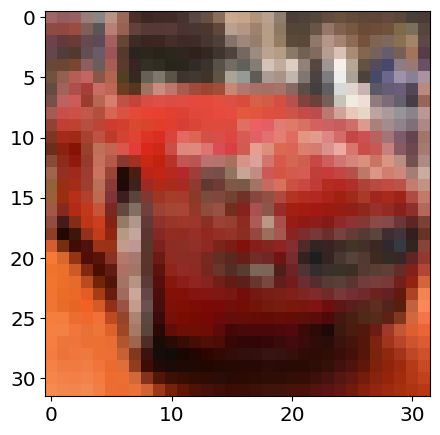

Номер класса: [1]


In [ ]:
n = 5
plt.imshow(X_train[n])
plt.show()
print("Номер класса:", y_train[n])

Разделение датасета

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.15,
                                                  stratify=np.array(y_train),
                                                  random_state=42)

In [ ]:
Y_train = np_utils.to_categorical(y_train, NUM_CLASSES)
Y_val = np_utils.to_categorical(y_val, NUM_CLASSES)
Y_test = np_utils.to_categorical(y_test, NUM_CLASSES)

* Поскольку мы собираемся использовать VGG16 в качестве экстрактора признаков, минимальный размер изображения, которое он принимает, составляет 48x48.

In [ ]:
X_train = np.array([sp.misc.imresize(x,
                                     (48, 48)) for x in X_train])
X_val = np.array([sp.misc.imresize(x,
                                   (48, 48)) for x in X_val])
X_test = np.array([sp.misc.imresize(x,
                                    (48, 48)) for x in X_test])

* Загрузить VGG16 без верхнего слоя классификации.
* Подготовьть пользовательский классификатор
* Наложить обе модели друг на друга

In [ ]:
base_model = vgg.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(48, 48, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Извлечение последнего слоя из третьего блока модели vgg16
last = base_model.get_layer('block3_pool').output

In [ ]:
# Добавьте слои классификации поверх него
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

Поскольку нашей целью является только обучение пользовательского классификатора, мы замораживаем слои VGG16

In [ ]:
for layer in base_model.layers:
     layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
# подготовка конфигурации увеличения данных
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [ ]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train,
                                     batch_size=BATCH_SIZE)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

# Тренировка модели

# Класс EarlyStopping
Этот класс реализует функционал ранней остаоновки. Так мы сможем избежать переобучения нейросети и остановить обучение раньше инициализированного количества эпох.

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0.01):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, losses):
        if (losses[0] - losses[1])/losses[0] <= self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [ ]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=1)

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=[early_stopping])

Epoch 1/40
1328/1328 [==============================] - 18s 8ms/step - loss: 0.2955 - accuracy: 0.3553 - val_loss: 0.2031 - val_accuracy: 0.5788
Epoch 2/40
1328/1328 [==============================] - 10s 8ms/step - loss: 0.2178 - accuracy: 0.5349 - val_loss: 0.1766 - val_accuracy: 0.6310
Epoch 3/40
1328/1328 [==============================] - 10s 7ms/step - loss: 0.1947 - accuracy: 0.5913 - val_loss: 0.1638 - val_accuracy: 0.6560
Epoch 4/40
1328/1328 [==============================] - 9s 7ms/step - loss: 0.1808 - accuracy: 0.6234 - val_loss: 0.1549 - val_accuracy: 0.6769
Epoch 5/40
1328/1328 [==============================] - 9s 7ms/step - loss: 0.1716 - accuracy: 0.6441 - val_loss: 0.1491 - val_accuracy: 0.6883
Epoch 6/40
1328/1328 [==============================] - 10s 8ms/step - loss: 0.1643 - accuracy: 0.6595 - val_loss: 0.1443 - val_accuracy: 0.7003
Epoch 7/40
1328/1328 [==============================] - 9s 7ms/step - loss: 0.1583 - accuracy: 0.6752 - val_loss: 0.1411 - val_accur

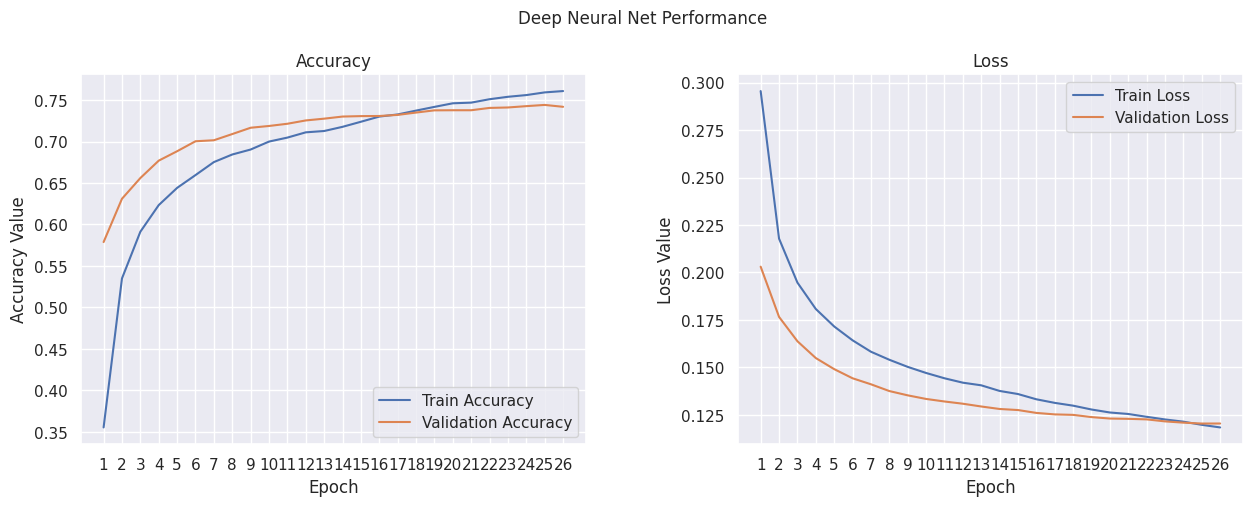

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,len(history.history['accuracy'])+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

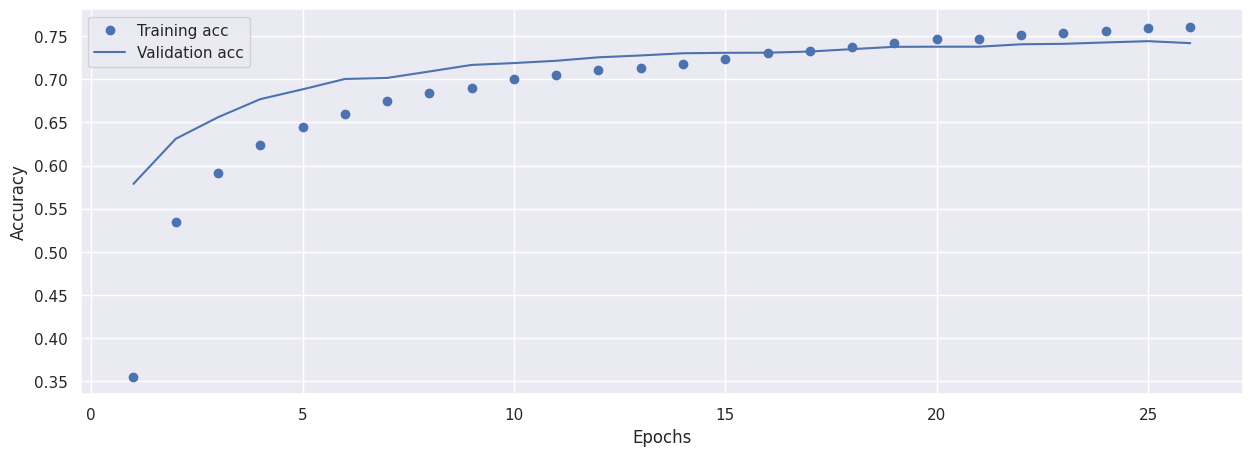

In [ ]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))

Точность работы на тестовых данных: 78.88%


# Визуализация предсказаний

In [ ]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

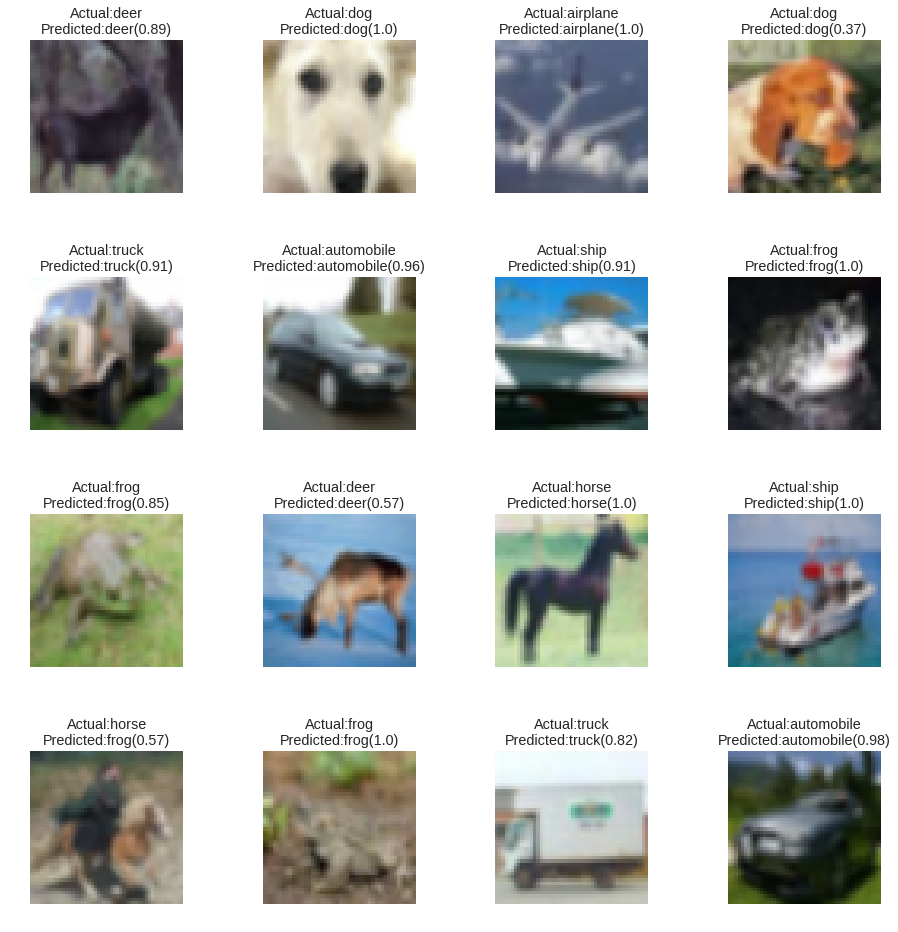

In [ ]:
utils.plot_predictions(model=model,dataset=X_test/255.,
                       dataset_labels=Y_test,
                       label_dict=label_dict,
                       batch_size=16,
                       grid_height=4,
                       grid_width=4)